# Coding Project 1 : Linear Regression and Regularization

**Tristan Þórðarson**




---


*Note:* The provided structure for the code below is only suggestive, and if you want to structure your programs differently you may do so.

### Question 1 - Importing the Data

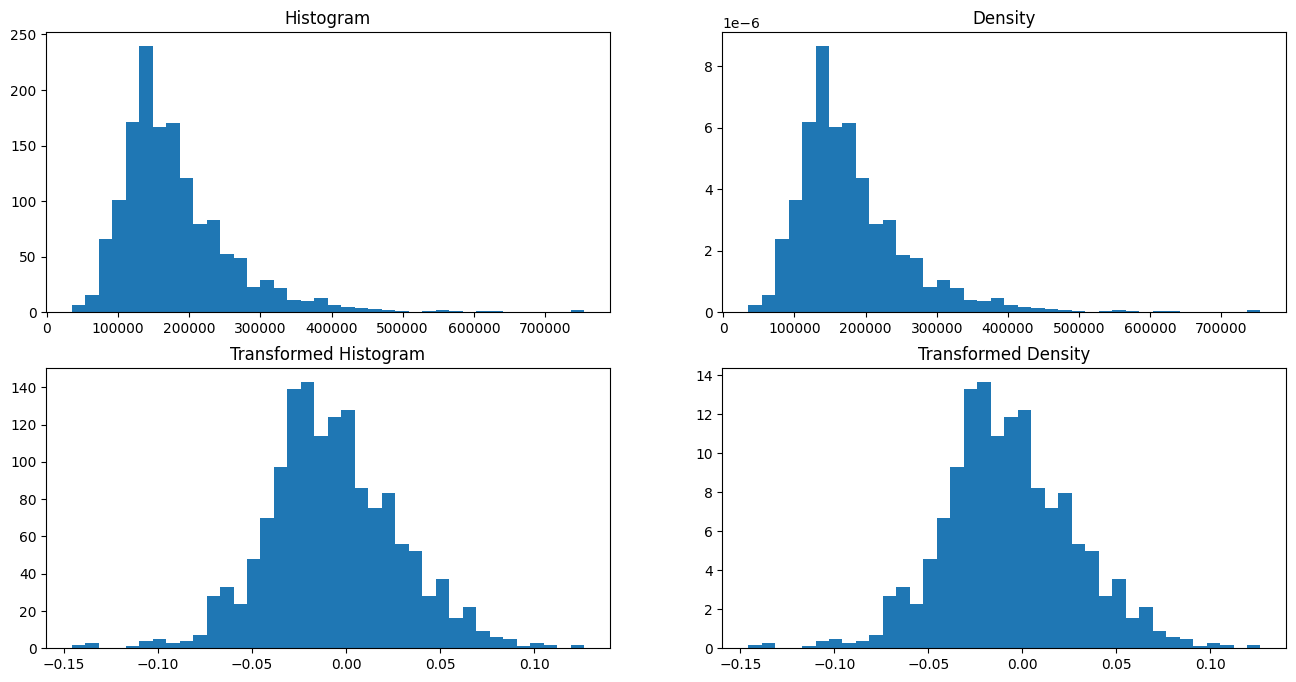

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.model_selection  import train_test_split

#1.a) Import the dataset Housing.csv into Python as a pandas DataFrame.
#To determine whether a variable is categorical or numerical, please refer to the file data_description.txt.
#Remember that the first column of the csv file is an index column and should not be considered as an explanatory variable.
data = pd.read_csv("Housing.csv")
data_keys = data.keys()
X = data[data_keys[1:-1]] # cutting col1: ID and last col (SalePrice)
y = data["SalePrice"]
nbins = int(np.sqrt(len(y)))

#1.b) Graphically determine whether the target variable SalePrice is approximately Gaussian.
fig, axs = plt.subplots(2,2,figsize=(16,8))
axs[0,0].hist(y,bins=nbins)
axs[0,0].set_title("Histogram")
axs[0,1].hist(y,density=True,bins=nbins)
axs[0,1].set_title("Density")

y_trans = (np.log(y)-np.log(y.mean())) / np.log(y.std())
axs[1,0].hist(y_trans,bins=nbins)
axs[1,0].set_title("Transformed Histogram")
axs[1,1].hist(y_trans,density=True,bins=nbins)
axs[1,1].set_title("Transformed Density")
plt.show()


#If not, suggest a suitable transformation to bring SalePrice closer to a Gaussian distribution (logarithmic, inverse, square-root, ...).

#Do not forget to apply this transformation to the target variable SalePrice in the dataset.

#Why is it important to consider such potential transformations?


#1.c) Split the data into a training set (X,y)_train and a test set (X,y)_test.
#Randomly assign 70% of the observations to the training set and the remaining 30% to the test set.


#1.d) Replace missing values in X using the training data statistics only -> use .fillna(...)
#For numerical features, replace missing values with the mean of the column .
#For categorical features, replace missing values with the most frequent category.
#You can use the function df.select_dtypes(...) to idetify categorical variables as the variables with type 'object' and 'category'. 
#Some categorical variables admit NA (or None) as a valid category, which should be treated as an actual level and not as missing.



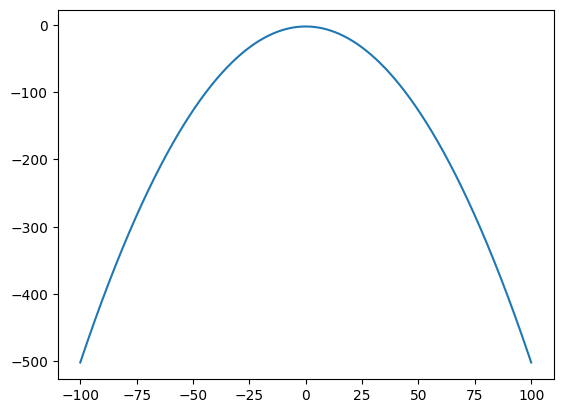

In [ ]:

def right_skewed_distribution(mu,sigma_sq,x):
    return 1/(np.sqrt(2*np.pi*sigma_sq)) * np.exp(-0.5*((x-mu)/np.sqrt(sigma_sq))**2)

def transformation_test(n):
    x = np.linspace(-100,100,n)
    y = (right_skewed_distribution(0,10,x))
    plt.plot(x,y)

transformation_test(10000)

##
$$\frac{1}{\sqrt{2\pi}} \exp \left(-\frac{1}{2}x^2 \right)$$

### Question 2 - Linear Regression on Numerical Features

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm

#2.a) Fit a linear regression model on the training dataset with numerical features only using the sklearn package.
#Output a table with the name of each feature and the associated regression coefficient.

#Compare the in-sample and out-of-sample Mean Squared Error (MSE) and R^2.


#2.b) (i) Compute the estimated coefficients for each explanatory variable using the numpy package. 
#Remember that the design matrix A needs to include a column of 1's. Use np.linalg.solve(...).

# (ii) Compute the standard error of each estimated coefficient using the numpy package.

# (iii) Compute the (in-sample) MSE and R^2 using the numpy package.

# (iv) Do the results change using pseudoinversion instead of standard matrix inversion? Use np.linalg.pinv(...).

# (v) Compare your results (with and without pseudoinversion) to the output of the sm.OLS(...) function.



### Question 3 - Regularization Techniques

In [4]:
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV, Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score, RepeatedKFold, KFold

# 3.a) Linear regression with the full Housing dataset (numerical + categorical).
#How do the in-sample and out-of-sample metrics change when including categorical features, and what does this reveal about the model’s ability to generalize?


#3.b) Implement the Truncated Pseudoinverse, Ridge, Lasso, and Elastic Net regularization techniques.
#Use 8-fold cross-validation to tune the hyperparameters of each regularization technique based on the MSE metric.
#Why is it important that the intercept is not penalized in these models?

#Compare their performance in terms of in-sample and out-of-sample MSE and R2 with the linear regressions of Questions 2.a) and 3.a).


#3.c) During cross-validation, what are possible sources of information leakage? 
#Briefly describe what leakage means in this context, and explain what steps you would take to avoid it if you were building a more complete data preprocessing pipeline (e.g., with imputation, scaling, or encoding). 
#You do not need to implement these steps here, only to explain the idea.


#3.d) For the  Lasso and Elastic Net regressions, how many coefficients are non-zero?

#Compare this number with the number of coefficients retained by the Ridge and Truncated Pseudoinverse models and provide an explanation.


#3.e) #Based on your findings from Questions 2 and 3, which model would you recommend for predicting house prices? 
#Justify your choice not only by comparing performance metrics, but also by discussing the nature of the problem (e.g., number of features, presence of categorical variables, potential collinearity, sparsity, nonlinearity). 
#Explain how the strengths and limitations of the chosen method align with this problem structure.

